## 0. Setup

In [1]:
#standard packages
import pandas as pd
import numpy as np
#import warnings
import warnings
warnings.filterwarnings('ignore')
import os
import collections

#time packages
import datetime as dt


In [2]:
from setup import main as setup
setup(env='vscode', project='cc_cid_calculator')

Project directory: /Users/luiz.superti/Documents/GitHub/alice-coding/cc_cid_calculator


In [3]:
from src.model import StaggDiD

***

## 1. extract

In [4]:
df = pd.read_csv('src/data/cid_care_cost_did_calc_df.csv')
df.columns

Index(['member_internal_code', 'calendar_date', 'mth_order', 'total_n_mth',
       'current_sex', 'current_gender', 'member_age', 'current_city',
       'current_state', 'is_b2b', 'is_pitaya', 'diseases_sev', 'tds_cost',
       'internacao_proced_cost', 'exam_cost', 'consulta_cost', 'er_cost',
       'alice_therapy_cost', 'other_costs', 'total_care_cost'],
      dtype='object')

In [5]:
df['diseases_'] = df['diseases_sev'].str.split(';')
df2 = df.explode('diseases_')
df2['cid_'] = df2['diseases_'].apply(lambda x: str(x).strip()[0:3])
df3 = df2[['member_internal_code','calendar_date', 'cid_']].drop_duplicates()

In [6]:
df3

,member_internal_code,calendar_date,cid_
0,NC1000Z,2022-05-31,nan
1,NC1000Z,2022-06-30,nan
2,NC1000Z,2022-07-31,nan
3,NC1002P,2021-12-31,nan
4,NC1002P,2022-01-31,nan
...,...,...,...
114409,NC1ZZWN,2022-05-31,R74
114410,NC1ZZWN,2022-06-30,R74
114411,NC1ZZWN,2022-07-31,R74
114412,NC1ZZWN,2022-08-31,N17


In [7]:
df_row = pd.get_dummies(df3['cid_'], prefix = 'cid')
df_row_2 = df3[['member_internal_code', 'calendar_date']].merge(df_row, how = 'inner', left_index=True, right_index=True)
df_row_3 = df_row_2.groupby(['member_internal_code', 'calendar_date']).max().reset_index()
df_row_3.sort_values(by=['member_internal_code', 'calendar_date'], inplace=True)
#create a cid filter
df_row_3.drop(columns = 'cid_nan', inplace = True)
cids_cols = [col for col in df_row_3 if col.startswith('cid_')]
df_row_3[cids_cols] = df_row_3[cids_cols].apply(pd.to_numeric).fillna(0)

***

In [8]:
df_filled = df.merge(
                    pd.get_dummies(df.current_state, prefix = 'uf'),how = 'inner', left_index=True, right_index=True).merge(
                        pd.get_dummies(df.current_city, prefix = 'city'),how = 'inner', left_index=True, right_index=True).drop(columns=['current_state', 'current_city'])
df_filled['is_male'] = np.where(df_filled['current_sex']=='MALE',1,0)
df_filled['is_trans'] = np.where(df_filled['current_sex']!=df_filled['current_gender'],1,0)
#create the base-dummies
df_filled.drop(columns=['current_gender','current_sex','city_São Paulo', 'uf_SP',
                        'diseases_sev','tds_cost', 'exam_cost', 'consulta_cost',
                        'internacao_proced_cost', 'er_cost',
                        'alice_therapy_cost', 'other_costs'], inplace=True)
df_filled.drop(columns=['diseases_'], inplace=True)

base_covariates_list = df_filled.drop(columns = ['member_internal_code', 'calendar_date', 'mth_order','total_n_mth', 'total_care_cost']).columns.to_list()
core_covariates = ['member_age', 'is_pitaya', 'is_male']
#y = ['total_care_cost']

### Merge bases

In [9]:
ml_df = df_filled.merge(df_row_3, how = 'inner', left_on=['member_internal_code', 'calendar_date'], right_on = ['member_internal_code', 'calendar_date'])

#adjust variables
ml_df['n_total_cids'] = ml_df[cids_cols].sum(axis=1)
ml_df['ref_mth'] = (pd.to_datetime(ml_df['calendar_date']).dt.to_period('M') -   pd.to_datetime(['1970-01-31']).to_period('M')).apply(lambda x: x.n)

#entry-calendar date
ml_df['v1'] = np.where(ml_df['mth_order']==1, ml_df['ref_mth'], np.nan)
ml_df = ml_df.merge(ml_df.groupby(['member_internal_code'])['v1'].min().rename('ref_mth_entrance_group'), how = 'inner', left_on = 'member_internal_code', right_index = True)
ml_df['ref_mth_entrance_group'] = ml_df['ref_mth_entrance_group'].astype('Int64')
ml_df.drop(columns = ['v1'], inplace = True)
ml_df.head(10)

,member_internal_code,calendar_date,mth_order,total_n_mth,member_age,is_b2b,is_pitaya,total_care_cost,uf_AC,uf_AL,...,cid_Z91,cid_Z92,cid_Z93,cid_Z95,cid_Z96,cid_Z97,cid_Z98,n_total_cids,ref_mth,ref_mth_entrance_group
0,NC1000Z,2022-05-31,1,3,33.0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,628,628
1,NC1000Z,2022-06-30,2,3,33.0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,629,628
2,NC1000Z,2022-07-31,3,3,34.0,0,0,16.019120,0,0,...,0,0,0,0,0,0,0,0,630,628
3,NC1002P,2021-12-31,1,9,26.0,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,623,623
4,NC1002P,2022-01-31,2,9,26.0,1,0,107.373738,0,0,...,0,0,0,0,0,0,0,0,624,623
5,NC1002P,2022-02-28,3,9,26.0,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,625,623
6,NC1002P,2022-03-31,4,9,26.0,1,0,18.990966,0,0,...,0,0,0,0,0,0,0,0,626,623
7,NC1002P,2022-04-30,5,9,26.0,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,627,623
8,NC1002P,2022-05-31,6,9,26.0,1,0,677.768498,0,0,...,0,0,0,0,0,0,0,1,628,623
9,NC1002P,2022-06-30,7,9,26.0,1,0,140.079314,0,0,...,0,0,0,0,0,0,0,2,629,623


In [10]:
ml_df_calendar_base = ml_df[['member_internal_code','calendar_date','mth_order','ref_mth', 'ref_mth_entrance_group']]
base_df = ml_df
accountable_cids = base_df.groupby('member_internal_code')[cids_cols].min().drop_duplicates().sum(axis=0).sort_values(ascending=False)
accountable_cids = accountable_cids[accountable_cids>=10].index.to_list()

***

In [11]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

logit = LogisticRegression()

# define pipeline 1
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline_compl_ = Pipeline(steps=steps)


# define pipeline 2
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('u', under)]
pipeline_under_ = Pipeline(steps=steps)


dd = StaggDiD

In [12]:
entry_list_cids = []
diagnosed_list  = []
results_df = pd.DataFrame()
for cid in accountable_cids:
    #cid_list not including the cid
    cid_list = [c for c in cids_cols if c!=cid]

    temp_df = pd.concat([ml_df_calendar_base, base_df[cid]], axis = 1)
    temp_df.sort_values(by = ['member_internal_code', 'calendar_date'], inplace = True)
    #
    lag_name = cid + '_lag_1'
    temp_df = pd.concat([temp_df,temp_df.groupby(['member_internal_code'])[cid].shift(1).rename(lag_name)], axis = 1)
    temp_df.sort_values(by = ['member_internal_code', 'calendar_date'], inplace = True)
    #
    entry_name = 'entry_' + cid
    diag_name = 'diag_' + cid
    #
    temp_df['v1'] = np.where((temp_df[cid]==1) & (temp_df['mth_order']==1), 1, 0)
    temp_df['ind_diag_mth'] = np.where((temp_df[cid]==1) & (temp_df[lag_name]!=1) & (temp_df['mth_order']>=2), 1, 0)
    temp_df = temp_df.merge(temp_df.groupby(['member_internal_code'])['v1'].max().rename(entry_name), how = 'inner', left_on = 'member_internal_code', right_index = True)
    temp_df = temp_df.merge(temp_df.groupby(['member_internal_code'])['ind_diag_mth'].max().rename(diag_name), how = 'inner', left_on = 'member_internal_code', right_index = True)
    temp_df.drop(columns = ['v1',lag_name], inplace = True)

    if temp_df[entry_name].mean()>0:
        print('current cid:', entry_name)
        print(' dataframe creation pt2')
        treat_group_mths = temp_df[temp_df[entry_name]==1]['ref_mth_entrance_group'].unique()
        control_group = temp_df[(temp_df['ref_mth_entrance_group'].isin(treat_group_mths)) & (temp_df[entry_name]==0) & (temp_df[entry_name]==0)]
        total_df = pd.concat([temp_df[temp_df[entry_name]==1], control_group], axis = 0)
        df = base_df[base_covariates_list + cid_list + ['total_care_cost'] + ['member_internal_code','mth_order', 'ref_mth_entrance_group']].merge(total_df[[entry_name] + ['ind_diag_mth']], how = 'inner', left_index = True, right_index = True)
        df = df.merge(df[df['ind_diag_mth']==1].groupby('member_internal_code')['mth_order'].max().rename('diag_mth_order'), how = 'left', left_on = 'member_internal_code', right_index = True)

        #keep those that were NOT diagnosed afterwards
        df = df[(df['diag_mth_order'].isna())|(df['diag_mth_order']==1)]

        X0 = df[df['mth_order']==1][base_covariates_list + cid_list]
        y0 = df[df['mth_order']==1][entry_name]
        
        print(' Propensity score matching w/ SMOTE and resampling')
        if (y0.mean()>=0.1) & (y0.value_counts()[1]>=10):
            X, y = pipeline_under_.fit_resample(X0, y0)

        elif (y0.mean()<0.1) & (y0.value_counts()[1]>=10):
            X, y = pipeline_compl_.fit_resample(X0, y0)

        else:
            print('     not enough samples to estimate propensity score')
        clf = logit.fit(X,y)
        pre_treat = clf.predict(df[df['mth_order']==1][base_covariates_list + cid_list])


        print(' dataframe creation pt2')
        df.loc[df['mth_order']==1, 'pre_treat'] = pre_treat
        df = df.merge(df.groupby(['member_internal_code'])['pre_treat'].max().rename('pre_treat_max'), how = 'inner', left_on = 'member_internal_code', right_index = True)
        df['treat'] = np.where(df[entry_name]==1, 1, 0)
        df.loc[(df['treat']==0) & (df['pre_treat_max']==0), 'treat'] = np.nan

        month_list = df[df[entry_name]==1]['ref_mth_entrance_group'].unique()
        new_ml_df = df[df['ref_mth_entrance_group'].isin(month_list) & (df['treat'].notna())][['member_internal_code','mth_order','ref_mth_entrance_group','treat', 'total_care_cost'] + core_covariates]
        #let's just maintain reference mths with overlapp of treatment and control:

        new_ml_df = new_ml_df.merge(new_ml_df.groupby(['ref_mth_entrance_group'])['treat'].mean().rename('max_treat_pp'), how = 'inner', left_on='ref_mth_entrance_group', right_index = True)
        new_ml_df = new_ml_df[(new_ml_df['max_treat_pp']>0) & (new_ml_df['max_treat_pp']<1)]

        print(' dataframe creation pt3: event analysis')
        new_df = pd.DataFrame()
        for pr_mth in new_ml_df['ref_mth_entrance_group'].unique():
            treat_df = new_ml_df[(new_ml_df['ref_mth_entrance_group']==pr_mth) & (new_ml_df['treat']==1)]
            treat_df['ev_an_mth'] = treat_df['mth_order'] - 1
            treat_df['id_group'] = treat_df['member_internal_code'].astype(str) 
            #
            control_df = new_ml_df[(new_ml_df['ref_mth_entrance_group']==pr_mth) & (new_ml_df['treat']==0)]
            control_df['ev_an_mth'] = control_df['mth_order'] - 1
            control_df['id_group'] = control_df['member_internal_code'].astype(str) 

            new_df = pd.concat([new_df,treat_df, control_df], axis = 0)

        final_ml_df = new_df.sort_values(['id_group','ev_an_mth'])
        final_ml_df.drop(columns = ['mth_order', 'member_internal_code'], inplace = True)

        print(' att_calculus')
        att_df = dd.att(final_ml_df, 'id_group', 'treat', 'total_care_cost', 'ev_an_mth', 0, 6)

        att_df['cid'] = cid[4:7]
        att_df['analysis_type'] = 'on_entry' 
        results_df = pd.concat([results_df, att_df], axis = 0)
        entry_list_cids.append(entry_name)

        try:
            del df, new_ml_df, new_df, final_ml_df, att_df, X0, y0,pre_treat,control_df,treat_df, X, y
        except:
            del df, new_ml_df, new_df, final_ml_df, att_df, X0, y0,pre_treat

    if temp_df[diag_name].mean()>0:
        print('current cid:', diag_name)
        #DF to estimate variables
        print(' dataframe creation pt1')

        treat_group_mths = temp_df[temp_df[diag_name]==1]['ref_mth_entrance_group'].unique()
        control_group = temp_df[(temp_df['ref_mth_entrance_group'].isin(treat_group_mths)) & (temp_df[diag_name]==0) & (temp_df[diag_name]==0)]
        total_df = pd.concat([temp_df[temp_df[diag_name]==1], control_group], axis = 0)
        df = base_df[base_covariates_list + cid_list + ['total_care_cost'] + ['member_internal_code','mth_order', 'ref_mth_entrance_group']].merge(total_df[[diag_name] + ['ind_diag_mth']], how = 'inner', left_index = True, right_index = True)
        df = df.merge(df[df['ind_diag_mth']==1].groupby('member_internal_code')['mth_order'].max().rename('diag_mth_order'), how = 'left', left_on = 'member_internal_code', right_index = True)

        X0 = df[df['mth_order']==1][base_covariates_list + cid_list]
        y0 = df[df['mth_order']==1][diag_name]

        print(' Propensity score matching w/ SMOTE and resampling')
        if (y0.mean()>=0.1) & (y0.value_counts()[1]>=10):
            X, y = pipeline_under_.fit_resample(X0, y0)

        elif (y0.mean()<0.1) & (y0.value_counts()[1]>=10):
            X, y = pipeline_compl_.fit_resample(X0, y0)

        else:
            print('     not enough samples to estimate propensity score')
            continue
        clf = logit.fit(X,y)
        pre_treat = clf.predict(df[df['mth_order']==1][base_covariates_list + cid_list])

        print(' dataframe creation pt2')
        df.loc[df['mth_order']==1, 'pre_treat'] = pre_treat # treatment allocation associated with the first month, as an output of the logit-ridge model
        df = df.merge(df.groupby(['member_internal_code'])['pre_treat'].max().rename('pre_treat_max'), how = 'inner', left_on = 'member_internal_code', right_index = True) #we need to keep the treatment allocation associated with the first month, to all of the other months 
        df['treat'] = np.where(df[diag_name]==1, 1, 0) #now to associate the cid in question to the 'treatment' variable
        df.loc[(df['treat']==0) & (df['pre_treat_max']==0), 'treat'] = np.nan #the others obs. that failed the logit (ie, =0) will not be considered

        month_list = df[df[diag_name]==1]['ref_mth_entrance_group'].unique()
        new_ml_df = df[df['ref_mth_entrance_group'].isin(month_list) & (df['treat'].notna())][['member_internal_code','mth_order','ref_mth_entrance_group','ind_diag_mth','diag_mth_order','treat', 'total_care_cost'] + core_covariates]
        #let's just maintain reference mths with overlapp of treatment and control:

        new_ml_df = new_ml_df.merge(new_ml_df.groupby(['ref_mth_entrance_group'])['treat'].mean().rename('max_treat_pp'), how = 'inner', left_on='ref_mth_entrance_group', right_index = True)
        new_ml_df = new_ml_df[(new_ml_df['max_treat_pp']>0) & (new_ml_df['max_treat_pp']<1)]
        print(' dataframe creation pt3: event analysis')
        new_df = pd.DataFrame()
        for pr_mth in new_ml_df['ref_mth_entrance_group'].unique():
            diag_months = new_ml_df[(new_ml_df['ind_diag_mth']==1) & (new_ml_df['ref_mth_entrance_group']==pr_mth)]['diag_mth_order'].unique()
            #print(pr_mth, diag_months)
            for mth in diag_months:
                treat_df = new_ml_df[(new_ml_df['ref_mth_entrance_group']==pr_mth) & (new_ml_df['treat']==1) & (new_ml_df['diag_mth_order']==mth)]
                treat_df['ev_an_mth'] = treat_df['mth_order'] - mth
                treat_df = treat_df.merge(treat_df.groupby('member_internal_code')['mth_order'].min().rename('min_mth_order'),how = 'inner', left_on='member_internal_code', right_index = True)
                treat_df = treat_df.merge(treat_df.groupby('member_internal_code')['ev_an_mth'].min().rename('min_ev_an_mth'),how = 'inner', left_on='member_internal_code', right_index = True)
                treat_df['id_group'] = treat_df['member_internal_code'].astype(str) + '_' + treat_df['min_ev_an_mth'].astype(str) + '_' + treat_df['min_mth_order'].astype(str)        
                treat_df.drop(columns = ['min_mth_order', 'min_ev_an_mth'], inplace = True)
                #
                control_df = new_ml_df[(new_ml_df['ref_mth_entrance_group']==pr_mth) & (new_ml_df['treat']==0)]
                control_df['ev_an_mth'] = control_df['mth_order'] - mth
                control_df = control_df.merge(control_df.groupby('member_internal_code')['mth_order'].min().rename('min_mth_order'),how = 'inner', left_on='member_internal_code', right_index = True)
                control_df = control_df.merge(control_df.groupby('member_internal_code')['ev_an_mth'].min().rename('min_ev_an_mth'),how = 'inner', left_on='member_internal_code', right_index = True)
                control_df['id_group'] = control_df['member_internal_code'].astype(str) + '_' + control_df['min_ev_an_mth'].astype(str) + '_' + control_df['min_mth_order'].astype(str)
                control_df.drop(columns = ['min_mth_order', 'min_ev_an_mth'], inplace = True)

                new_df = pd.concat([new_df,treat_df, control_df], axis = 0)

        final_ml_df = new_df.sort_values(['id_group','ev_an_mth'])
        final_ml_df.drop(columns = ['mth_order', 'diag_mth_order', 'ind_diag_mth', 'member_internal_code'], inplace = True)

        #     
        print(' att_calculus')
        att_df = dd.att(final_ml_df, 'id_group', 'treat', 'total_care_cost', 'ev_an_mth', -3, 6)

        att_df['cid'] = cid[4:7]
        att_df['analysis_type'] = 'after_entry' 
        results_df = pd.concat([results_df, att_df], axis = 0)
        diagnosed_list.append(diag_name)

        #conditional deletion
        try:
            del df, new_ml_df, new_df, final_ml_df, att_df, X0, y0,pre_treat,control_df,treat_df, X, y
        except:
            del df, new_ml_df, new_df, final_ml_df, att_df, X0, y0,pre_treat    

current cid: entry_cid_H52
 dataframe creation pt2
 Propensity score matching w/ SMOTE and resampling
 dataframe creation pt2
 dataframe creation pt3: event analysis
 att_calculus
current cid: diag_cid_H52
 dataframe creation pt1
 Propensity score matching w/ SMOTE and resampling
 dataframe creation pt2
 dataframe creation pt3: event analysis
 att_calculus
current cid: entry_cid_F41
 dataframe creation pt2
 Propensity score matching w/ SMOTE and resampling
 dataframe creation pt2
 dataframe creation pt3: event analysis
 att_calculus
current cid: diag_cid_F41
 dataframe creation pt1
 Propensity score matching w/ SMOTE and resampling
 dataframe creation pt2
 dataframe creation pt3: event analysis
 att_calculus
current cid: entry_cid_E66
 dataframe creation pt2
 Propensity score matching w/ SMOTE and resampling
 dataframe creation pt2
 dataframe creation pt3: event analysis
 att_calculus
current cid: diag_cid_E66
 dataframe creation pt1
 Propensity score matching w/ SMOTE and resampling
 

***

***

In [13]:
#adding significant column
results_df['is_signicant'] = np.nan
results_df['after_entry_analysis_is_valid'] = np.nan

In [14]:
results_df.loc[(results_df['analysis_type'] == 'after_entry') & (results_df['lower_bound'] > 0)  & (results_df['time'] >= 0), 'is_signicant'] = 1
results_df.loc[(results_df['analysis_type'] == 'on_entry') & (results_df['lower_bound'] > 0)  & (results_df['time'] >= 1), 'is_signicant'] = 1

results_df = results_df.merge(results_df.groupby(['cid','analysis_type'])['is_signicant'].max().rename('v1'), how = 'inner', left_on = ['cid','analysis_type'], right_index = True)
del results_df['is_signicant']
results_df.rename(columns = {'v1':'is_signicant'}, inplace = True)
results_df['is_signicant'].fillna(0, inplace = True)


####################################
results_df.loc[(results_df['analysis_type'] == 'after_entry') & (results_df['time']< -1), 'after_entry_analysis_is_valid'] = 0
results_df.loc[(results_df['analysis_type'] == 'after_entry') & (results_df['time']< -1)  & (results_df['lower_bound'] < 0) & (results_df['upper_bound'] > 0), 'after_entry_analysis_is_valid'] = 1
results_df = results_df.merge(results_df.groupby(['cid','analysis_type'])['after_entry_analysis_is_valid'].mean().rename('v1'), how = 'inner', left_on = ['cid','analysis_type'], right_index = True)
del results_df['after_entry_analysis_is_valid']
results_df.rename(columns = {'v1':'after_entry_analysis_is_valid'}, inplace = True)
results_df['after_entry_analysis_is_valid'] = np.where(results_df['after_entry_analysis_is_valid'] < 1, 0, results_df['after_entry_analysis_is_valid'] )
results_df.loc[(results_df['analysis_type'] == 'after_entry')] ['after_entry_analysis_is_valid'].fillna(0, inplace = True)

In [15]:
results_df

,time,lower_bound,mean,upper_bound,cid,analysis_type,is_signicant,after_entry_analysis_is_valid
0,0,0.000000,0.000000,0.000000,H52,on_entry,0.0,NaN
1,1,-284.809917,-64.632892,155.544132,H52,on_entry,0.0,NaN
2,2,-281.795380,-84.301562,113.192257,H52,on_entry,0.0,NaN
3,3,-115.104992,81.723470,278.551932,H52,on_entry,0.0,NaN
4,4,-210.473347,-12.944907,184.583532,H52,on_entry,0.0,NaN
...,...,...,...,...,...,...,...,...
5,2,-15011.918796,-5173.914863,4664.089070,X06,after_entry,0.0,1.0
6,3,-16366.110913,-5202.327637,5961.455640,X06,after_entry,0.0,1.0
7,4,-28780.237142,-9679.246928,9421.743286,X06,after_entry,0.0,1.0
8,5,-196.046025,596.066170,1388.178365,X06,after_entry,0.0,1.0


In [17]:
results_df.to_csv('src/data/cidinha_care_cost_calculator.csv', index = False)

In [16]:
#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.style as style
import matplotlib.patches as mpatches

In [27]:
coef_df = results_df[(results_df['cid']=='H52') & (results_df['analysis_type']=='after_entry')]

In [28]:
coef_df 

,time,lower_bound,mean,upper_bound,cid,analysis_type,is_signicant,after_entry_analysis_is_valid
0,-3,-169.238408,22.408173,214.054753,H52,after_entry,1.0,1.0
1,-2,-325.409481,-75.794522,173.820437,H52,after_entry,1.0,1.0
2,-1,0.000000,0.000000,0.000000,H52,after_entry,1.0,1.0
3,0,494.958778,652.131181,809.303584,H52,after_entry,1.0,1.0
4,1,356.806006,563.024945,769.243883,H52,after_entry,1.0,1.0
5,2,191.544330,395.739310,599.934289,H52,after_entry,1.0,1.0
6,3,124.690016,317.172335,509.654655,H52,after_entry,1.0,1.0
7,4,88.961164,308.980186,528.999207,H52,after_entry,1.0,1.0
8,5,-82.520285,510.869465,1104.259215,H52,after_entry,1.0,1.0
9,6,-87.794198,467.212309,1022.218815,H52,after_entry,1.0,1.0


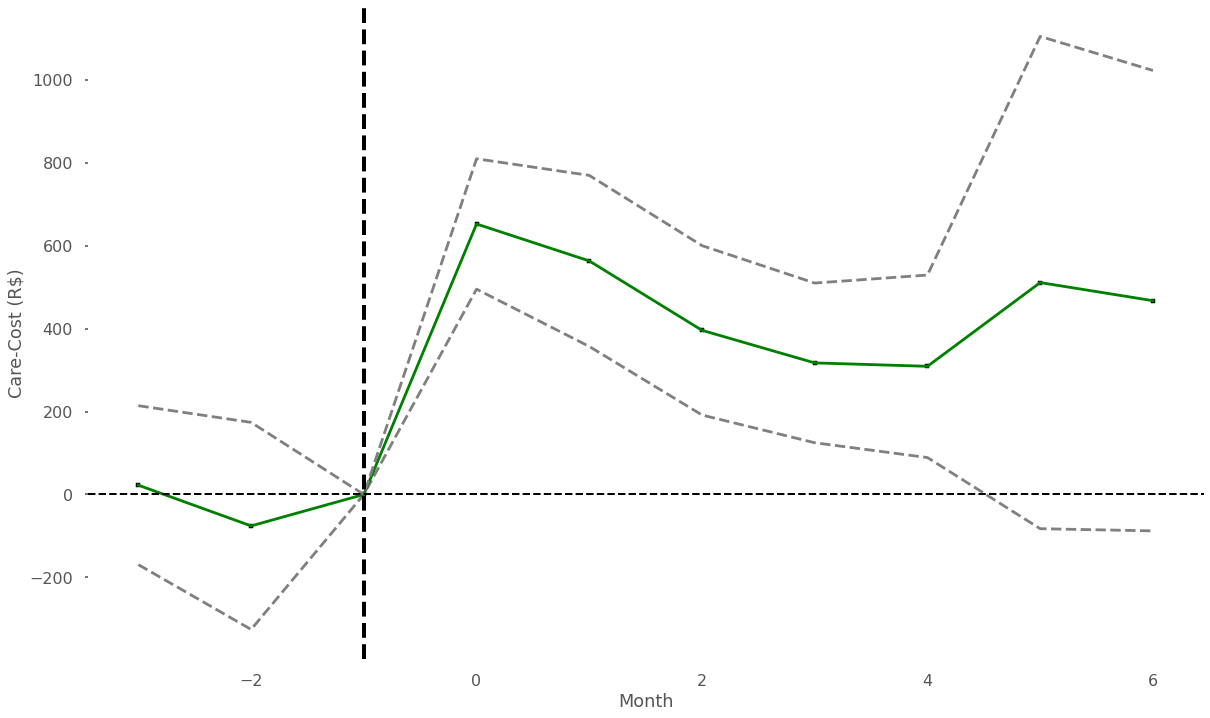

In [29]:
style.use('ggplot')

style.use('seaborn-poster')

fig, ax = plt.subplots(figsize=(20, 12))
coef_df.plot(x='time', y='lower_bound', kind='line', linestyle = '--',
             ax=ax, color='grey', label='95% CI LB', legend=False)

coef_df.plot(x='time', y='mean', kind='line', linestyle = '-',
             ax=ax, color='green', label='95% CI LB', legend=False)

coef_df.plot(x='time', y='upper_bound', kind='line', linestyle = '--',
             ax=ax, color='grey', label='95% CI UB', legend=False)

ax.set_ylabel('Care-Cost (R$)')
ax.set_xlabel('Month')


ax.scatter(x=coef_df['time'], 
           marker='s', s=10,
           y=coef_df['mean'], color='black')

ax.axhline(y=0, linestyle='--', color='black', linewidth=2)


ax.axvline(x=-1, linestyle='--', color='black', linewidth=4)


ax.xaxis.set_ticks_position('none')
#_ = ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9'], 
#                       rotation=0, fontsize=16)

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('white')

plt.show()

***

In [ ]:
ml_df.to_csv('src/data/panel_cc_cids_did_df.csv', index = False)